# Data Augmentation


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Imports

In [1]:
from torchvision import datasets
import torchvision
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import PIL


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd

## Settings

In [3]:
####
##Settings 
####

randomSeed= 100
batchSize = 128
numEpochs = 100


## Custom Transform

In [4]:
trainingTransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.RandomCrop(size=(28,28)),
    torchvision.transforms.RandomRotation(degrees = 30, interpolation = PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

In [5]:
testingTransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(32,32)),
    torchvision.transforms.CenterCrop(size=(28,28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,),std=(0.5,)),
])

In [6]:
trainData = datasets.MNIST(root = 'data',
                          train = True,
                          transform = trainingTransform,
                          download = True)

testData = datasets.MNIST(root = 'data',
                         train = False,
                         transform = testingTransform)



100%|██████████| 9912422/9912422 [00:00<00:00, 76165520.91it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40690525.30it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20546198.17it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6760301.20it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Data Loader

In [7]:
trainLoader = DataLoader(dataset = trainData,
                        batch_size = batchSize,
                        shuffle = True)
testLoader = DataLoader(dataset = testData,
                       batch_size = batchSize,
                       shuffle = False)

## DataOutPuts

In [8]:
random.seed(0)
torch.manual_seed(0)

for images,labels in trainLoader:
    print("Image Batch Dimensions", images.shape)
    print("Image Label Dimensions", labels.shape)
    break

Image Batch Dimensions torch.Size([128, 1, 28, 28])
Image Label Dimensions torch.Size([128])


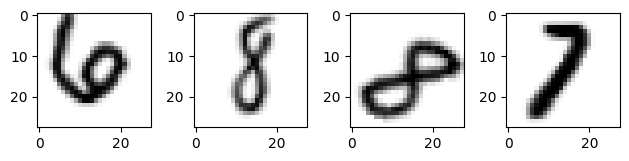

In [9]:
fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(images[i].view(28,28).numpy(), cmap='binary')
plt.tight_layout()


In [10]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## One Hot Encoding

In [11]:
def toOneHot(y,nClasses):
  yOneHot = torch.FloatTensor(y.size(0),nClasses)
  yOneHot.zero_()
  tmp = y.view(-1,1).long().to(torch.device('cpu'))
  yOneHot.scatter_(1,tmp,1).float()
  return yOneHot

## Model

In [12]:
class mlpSoftmax(torch.nn.Module):

  def __init__(self,numFeatures,numHidden,numClasses):
    super(mlpSoftmax,self).__init__()

    self.numClasses = numClasses

    self.linearLayer = torch.nn.Linear(numFeatures,numHidden)
    self.linearLayer.weight.detach().normal_(0,0.1)
    self.linearLayer.bias.detach().normal_(0)

    self.linearOut = torch.nn.Linear(numHidden,numClasses)
    self.linearOut.weight.detach().normal_(0,0.1)
    self.linearOut.bias.detach().normal_(0)

  def forward(self,x):
    out = self.linearLayer(x)
    out = torch.sigmoid(out)
    logits = self.linearOut(out)
    return logits



## Model Initialization

In [13]:
torch.manual_seed(randomSeed)

In [14]:
model = mlpSoftmax(numFeatures=784,numHidden=100,numClasses=10)
model.to(DEVICE)

mlpSoftmax(
  (linearLayer): Linear(in_features=784, out_features=100, bias=True)
  (linearOut): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)

In [16]:
def computeLoss(net,dataLoader):
  totalLoss = 0.
  with torch.no_grad():
      for cnt , (features,targets) in enumerate(dataLoader):
        features = features.view(-1,28*28)
        # targets = targets.view(-1).float()
        targets = toOneHot(targets,net.numClasses)
        logits = model(features)
        loss = F.cross_entropy(logits,targets)
        totalLoss+=loss
      return totalLoss/cnt

## Training

In [17]:
startTime = time.time()
miniBatchCost = []
epochCost = []
for e in range(numEpochs):
  model.train()
  for batchIDx, (features,targets) in enumerate(trainLoader):
    features = features.view(-1,28*28)
    # targets = targets.view(-1).float()
    targets = toOneHot(targets,model.numClasses)
    logits = model(features)
    cost = F.cross_entropy(logits,targets)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    miniBatchCost.append(cost.item())
    if(not batchIDx % 50):
      print("Epoch %03d/%03d | Batch %03d/%03d | Cost: %.4f" % (e+1,numEpochs,batchIDx,len(trainLoader),cost.item()))
  epoCost = computeLoss(model,trainLoader)
  print("Epoch %03d/%03d | Cost: %.4f" % (e+1,numEpochs,epoCost))
  print("Time: %.2f min" %((time.time()-startTime)/60))
  epochCost.append(epoCost)
#   break
print("Total Time: %.2f min" %((time.time()-startTime)/60))




Epoch 001/100 | Batch 000/469 | Cost: 2.5804
Epoch 001/100 | Batch 050/469 | Cost: 1.9584
Epoch 001/100 | Batch 100/469 | Cost: 1.5816
Epoch 001/100 | Batch 150/469 | Cost: 1.5022
Epoch 001/100 | Batch 200/469 | Cost: 1.3251
Epoch 001/100 | Batch 250/469 | Cost: 1.2756
Epoch 001/100 | Batch 300/469 | Cost: 1.3179
Epoch 001/100 | Batch 350/469 | Cost: 1.2154
Epoch 001/100 | Batch 400/469 | Cost: 1.0277
Epoch 001/100 | Batch 450/469 | Cost: 1.0397
Epoch 001/100 | Cost: 1.0754
Time: 0.98 min
Epoch 002/100 | Batch 000/469 | Cost: 1.0785
Epoch 002/100 | Batch 050/469 | Cost: 1.1593
Epoch 002/100 | Batch 100/469 | Cost: 1.1505
Epoch 002/100 | Batch 150/469 | Cost: 0.9723
Epoch 002/100 | Batch 200/469 | Cost: 1.0429
Epoch 002/100 | Batch 250/469 | Cost: 0.9094
Epoch 002/100 | Batch 300/469 | Cost: 1.0973
Epoch 002/100 | Batch 350/469 | Cost: 1.1705
Epoch 002/100 | Batch 400/469 | Cost: 0.8767
Epoch 002/100 | Batch 450/469 | Cost: 0.9647
Epoch 002/100 | Cost: 0.9195
Time: 1.95 min
Epoch 003/10

## Evaluation

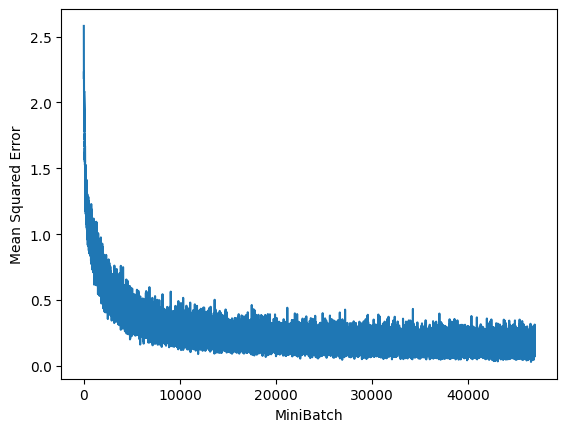

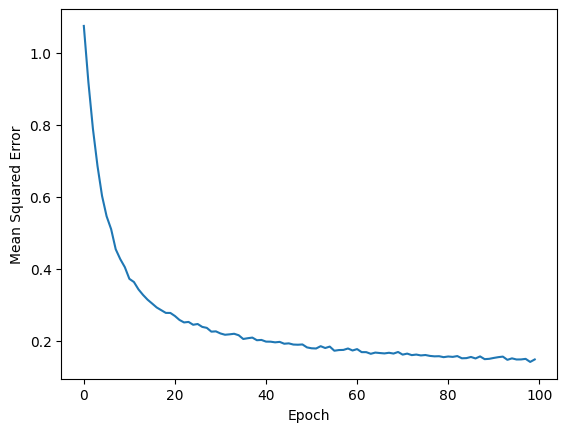

In [18]:
plt.plot(range(len(miniBatchCost)),miniBatchCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("MiniBatch")
plt.show()

plt.plot(range(len(epochCost)),epochCost)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epoch")
plt.show()

In [19]:
def computeAcc(net,dataLoader):
  correctPred,numExamples = 0 , 0
  with torch.no_grad():
    for features,targets in dataLoader:
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
        logits = net.forward(features)
        pred = torch.argmax(logits, 1)
#         num_examples += targets.size(0)
        numExamples+=targets.size(0)
        correctPred+=(pred==targets).sum()
      # yOneHot = toOneHot(targets,model.numClasses)
      # loss = torch.sum((yOneHot - probas)**2, dim=0)
      # numExamples+=targets.size(0)
      # currMSE+=loss
    # currMSE = torch.mean(currMSE/numExamples, dim=0)
    return correctPred.float()/numExamples * 100


In [20]:
print("Training Accuracy :%.2f" % (computeAcc(model,trainLoader)))
print("Testing  Accuracy :%.2f" % (computeAcc(model,testLoader )))


Training Accuracy :95.58
Testing  Accuracy :97.72
